<a href="https://colab.research.google.com/github/Saim-Khalid/Tuberculosis-Classification/blob/main/Tuberclosis_Classifier_with_EfficientNet_Augmented_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tuberculosis Classification using Chest X-Ray Images**

**Scope**

Fast and accurate medical diagnoses of tuberculosis is more important than ever. The current computer vision and deep learning technology have made this possible. We applied an EfficientNet model to identify Tuberculosis cases in the test set. After training the model will be able to classify Tuberculosis x-ray images from normal x-ray images.

## **Importing Necessary Libraries**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm #Helper Library to show Progress Bar

## **Helper Funtions**

In [ ]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['Normal', 'Tuberculosis']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

## **Configuration & Loading Dataset**

Datasource: [Tuberculosis Chest X-Ray Dataset](https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset) 

1.   The Dataset was downloaded from Kaggle and Divided with as 70% for training, 20% for testing and 10% for validation. 

2.   This Dataset contains contians Two Classes named as "Normal" and "Tuberculosis"

    *   **Normal = 3500**
    *   **Tuberculosis = 700**

3.   As the dataset was imbalanced, the **Tuberculosis** images for training set was augmented in Comparison to **Normal** images.

4.   I used Albumentation fo augmentation, as the difference was big so multiple augmentation techniques are applied to balance the dataset. For Augementation you can refer to [Data Augmentation using Albumentation](https://)

5.   Following Augmenations were applied to the dataset 

      *   **Horizontal Flip & Sharpening**
      *   **Random Contrast Brightness**
      *   **Scaling**
      *   **CLAHE (Contrast Limited Adaptive Histogram Equalization)**

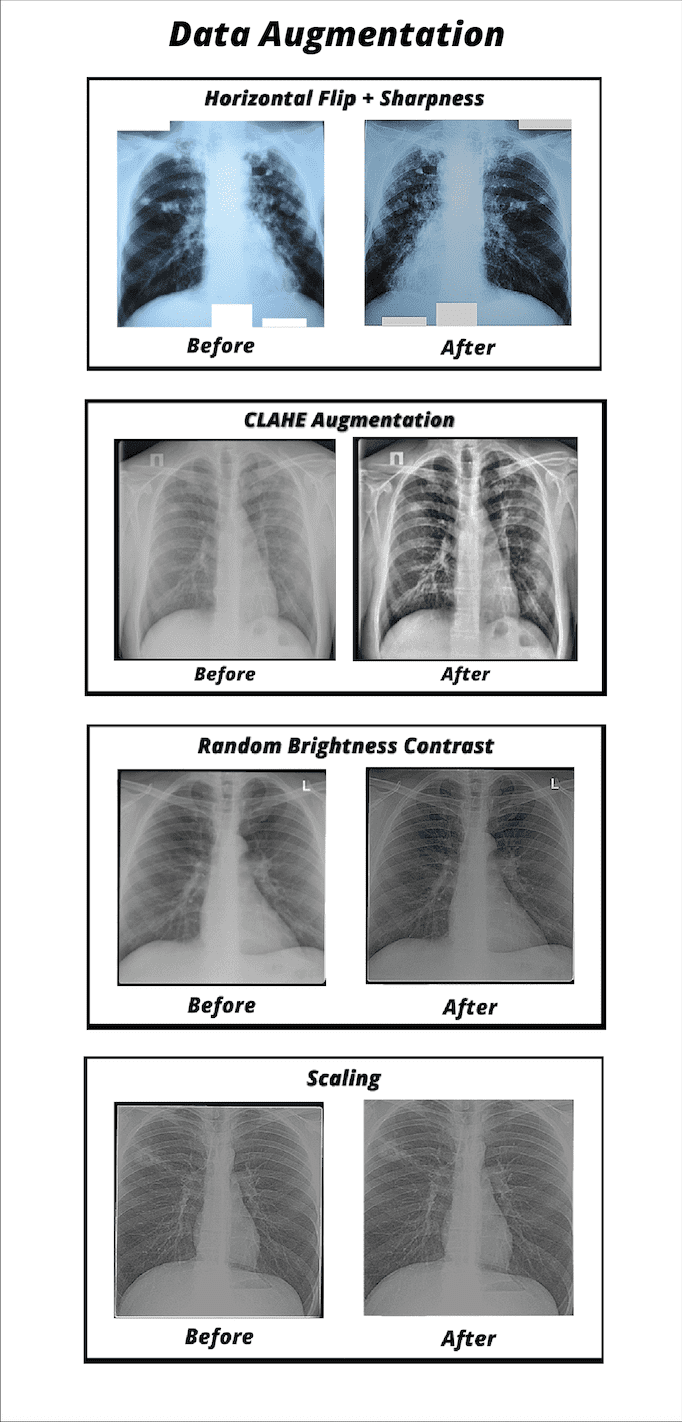




In [ ]:
class CFG:

  epochs = 60                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset, Just provide the links to the data from Google Drive
  train_path='/content/drive/MyDrive/Dataset_Pytorch/train'
  validate_path='/content/drive/MyDrive/Dataset_Pytorch/val'
  test_path='/content/drive/MyDrive/Dataset_Pytorch/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


## **Data Manipulation**

Here we are tranforming the dataset set we have loaded from Google drive.


1.   First the images from train, test and validation are resized to 224x224.
2.   After resizing the imgaes are converted to tensor and Normalized after that.

**Note: Pytorch Based Augmentation can also be performed in this step**



In [ ]:
from torchvision import transforms as T,datasets

In [ ]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

## **Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Displaying No of images in the Dataset**

### Train Set Size

In [ ]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  4903


### Validation Set Size

In [ ]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  420


### Test Set Size

In [ ]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  840


### Random Image Visualisation

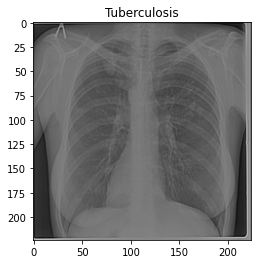

In [ ]:
img,label = trainset[3444]
#print(trainset.class_to_idx)

class_name =["Normal","Tuberculosis"]
show_image(img,class_name[label])

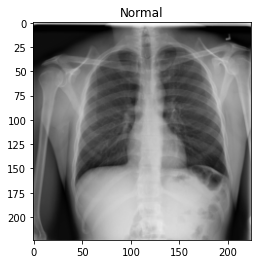

In [ ]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["Normal","Tuberculosis"]
show_image(img,class_name[label]) 

# randomly rotated if performed

## **Loading Data in Batches**

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:307
No. of Total examples:4903


In [ ]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:27
No. of Total examples:420


In [ ]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:53
No. of Total examples:840


### Some of the images in the training set after loading data

In [ ]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

AttributeError: ignored

## **Preparing Model**

In [ ]:
!pip install timm # install PyTorch Image Models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 32.9 MB/s 
     |████████████████████████████████| 182 kB 80.6 MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

### Transfer Learning

In [ ]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

## Final Model Summary

In [ ]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

## **Training the Model**

### Helper Functions for Training

In [ ]:
class TuberclosisTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabTuberclosisModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

### Focal Loss Funtion to handle Class imbalance

*Note: No focal loss was applied becuase the data was already balanced, but if you have imbalanced data, focal loss can be applied*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=1, alpha=0.25, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = TuberclosisTrainer(criterion,optimizer)
hist = trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.1033923330337361
Epoch : 1 Train Loss : 0.159356 Train Acc : 0.940554
Epoch : 1 Valid Loss : 0.103392 Valid Acc : 0.960648


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.1033923330337361 --> 0.10325396595591749
Epoch : 2 Train Loss : 0.098750 Train Acc : 0.964373
Epoch : 2 Valid Loss : 0.103254 Valid Acc : 0.951389


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.092526 Train Acc : 0.965391
Epoch : 3 Valid Loss : 0.111686 Valid Acc : 0.951389


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.075249 Train Acc : 0.974290
Epoch : 4 Valid Loss : 0.208070 Valid Acc : 0.921296


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.10325396595591749 --> 0.0764795273878715
Epoch : 5 Train Loss : 0.067949 Train Acc : 0.975977
Epoch : 5 Valid Loss : 0.076480 Valid Acc : 0.974537


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.0764795273878715 --> 0.07360930820599336
Epoch : 6 Train Loss : 0.068402 Train Acc : 0.976792
Epoch : 6 Valid Loss : 0.073609 Valid Acc : 0.972222


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.050846 Train Acc : 0.983510
Epoch : 7 Valid Loss : 0.136253 Valid Acc : 0.946759


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.063299 Train Acc : 0.979438
Epoch : 8 Valid Loss : 0.087109 Valid Acc : 0.962963


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.048095 Train Acc : 0.982288
Epoch : 9 Valid Loss : 0.100108 Valid Acc : 0.962963


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.07360930820599336 --> 0.06273249047734242
Epoch : 10 Train Loss : 0.042339 Train Acc : 0.983713
Epoch : 10 Valid Loss : 0.062732 Valid Acc : 0.976852


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.040614 Train Acc : 0.985546
Epoch : 11 Valid Loss : 0.095416 Valid Acc : 0.951389


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.06273249047734242 --> 0.0625568147812306
Epoch : 12 Train Loss : 0.043568 Train Acc : 0.983917
Epoch : 12 Valid Loss : 0.062557 Valid Acc : 0.979167


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.043831 Train Acc : 0.984935
Epoch : 13 Valid Loss : 0.071927 Valid Acc : 0.974537


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.031817 Train Acc : 0.989007
Epoch : 14 Valid Loss : 0.075401 Valid Acc : 0.972222


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.0625568147812306 --> 0.05605035037108421
Epoch : 15 Train Loss : 0.027156 Train Acc : 0.991246
Epoch : 15 Valid Loss : 0.056050 Valid Acc : 0.974537


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.05605035037108421 --> 0.048389795344081464
Epoch : 16 Train Loss : 0.031505 Train Acc : 0.988192
Epoch : 16 Valid Loss : 0.048390 Valid Acc : 0.988426


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.034392 Train Acc : 0.987174
Epoch : 17 Valid Loss : 0.078833 Valid Acc : 0.967593


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.029805 Train Acc : 0.988803
Epoch : 18 Valid Loss : 0.081469 Valid Acc : 0.965278


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.039441 Train Acc : 0.986767
Epoch : 19 Valid Loss : 0.138693 Valid Acc : 0.946759


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.033960 Train Acc : 0.990839
Epoch : 20 Valid Loss : 0.091393 Valid Acc : 0.974537


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.036336 Train Acc : 0.987785
Epoch : 21 Valid Loss : 0.112599 Valid Acc : 0.958333


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.028958 Train Acc : 0.990577
Epoch : 22 Valid Loss : 0.060767 Valid Acc : 0.979167


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.039917 Train Acc : 0.987116
Epoch : 23 Valid Loss : 0.063318 Valid Acc : 0.972222


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.037129 Train Acc : 0.987785
Epoch : 24 Valid Loss : 0.062801 Valid Acc : 0.979167


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.019908 Train Acc : 0.991857
Epoch : 25 Valid Loss : 0.070335 Valid Acc : 0.981481


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 26 Train Loss : 0.030913 Train Acc : 0.990839
Epoch : 26 Valid Loss : 0.066342 Valid Acc : 0.979167


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 27 Train Loss : 0.021900 Train Acc : 0.993282
Epoch : 27 Valid Loss : 0.081295 Valid Acc : 0.967593


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 0.029299 Train Acc : 0.990228
Epoch : 28 Valid Loss : 0.068696 Valid Acc : 0.983796


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 29 Train Loss : 0.018561 Train Acc : 0.993689
Epoch : 29 Valid Loss : 0.073341 Valid Acc : 0.972222


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 30 Train Loss : 0.021336 Train Acc : 0.992467
Epoch : 30 Valid Loss : 0.053830 Valid Acc : 0.983796


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 31 Train Loss : 0.021131 Train Acc : 0.993078
Epoch : 31 Valid Loss : 0.078647 Valid Acc : 0.983796


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 0.025865 Train Acc : 0.989821
Epoch : 32 Valid Loss : 0.071644 Valid Acc : 0.974537


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 33 Train Loss : 0.029024 Train Acc : 0.990839
Epoch : 33 Valid Loss : 0.089349 Valid Acc : 0.962963


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 34 Train Loss : 0.022326 Train Acc : 0.993485
Epoch : 34 Valid Loss : 0.053000 Valid Acc : 0.976852


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 0.023153 Train Acc : 0.992467
Epoch : 35 Valid Loss : 0.086400 Valid Acc : 0.969907


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 36 Train Loss : 0.027650 Train Acc : 0.990984
Epoch : 36 Valid Loss : 0.065432 Valid Acc : 0.976852


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 37 Train Loss : 0.021274 Train Acc : 0.992264
Epoch : 37 Valid Loss : 0.063300 Valid Acc : 0.972222


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 38 Train Loss : 0.016449 Train Acc : 0.994096
Epoch : 38 Valid Loss : 0.052740 Valid Acc : 0.981481


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Valid_loss decreased 0.048389795344081464 --> 0.04112976548899665
Epoch : 39 Train Loss : 0.023667 Train Acc : 0.992613
Epoch : 39 Valid Loss : 0.041130 Valid Acc : 0.990741


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : 40 Train Loss : 0.020182 Train Acc : 0.993485
Epoch : 40 Valid Loss : 0.055430 Valid Acc : 0.983796


### Testing the model

In [ ]:
model.load_state_dict(torch.load('/content/ColabTuberclosisModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/53 [00:00<?, ?it/s]

Test Loss : 0.1042066113006753
Test Acc : 0.9752358198165894


## **Confusion Matrix for Test Dataset**

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


In [ ]:
print(y_pred)
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
class_names = ('Nomral', 'Tuberculosis')

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

### Confusion Matrix

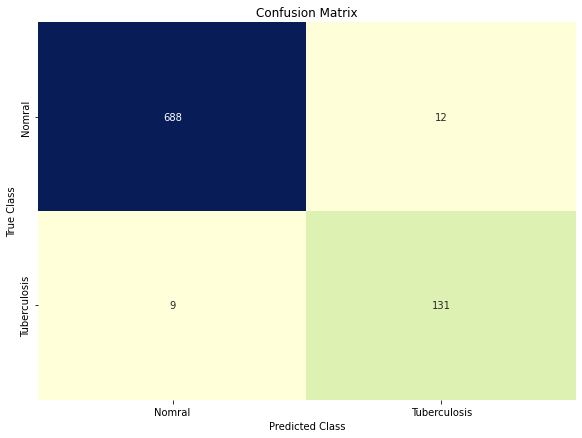

In [ ]:
#confusion matrix for test
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 


              precision    recall  f1-score   support

      Nomral       0.99      0.98      0.98       700
Tuberculosis       0.92      0.94      0.93       140

    accuracy                           0.97       840
   macro avg       0.95      0.96      0.96       840
weighted avg       0.98      0.97      0.98       840



## **Confusion Matrix for Validationset**

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in tqdm(validationloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 27/27 [00:07<00:00,  3.74it/s]


In [ ]:
print(y_pred)
print(y_true)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
class_names = ('Nomral', 'Tuberculosis')

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

### Confusion Matrix

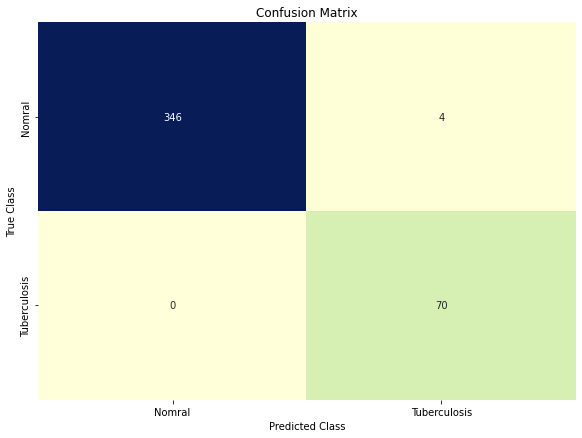

In [ ]:
#confusion matrix for test
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names)) 

              precision    recall  f1-score   support

      Nomral       1.00      0.99      0.99       350
Tuberculosis       0.95      1.00      0.97        70

    accuracy                           0.99       420
   macro avg       0.97      0.99      0.98       420
weighted avg       0.99      0.99      0.99       420



## **Predictions**

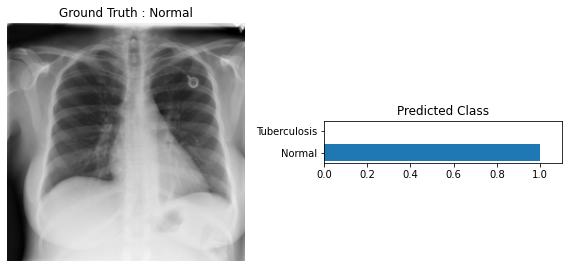

In [ ]:
import torch.nn.functional as F

image,label = testset[74]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

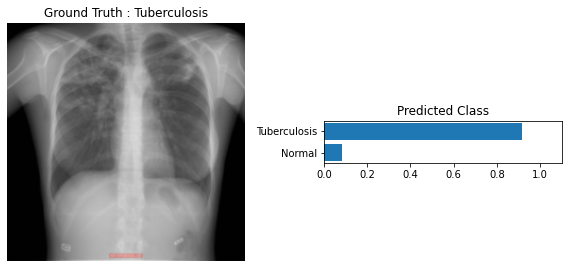

In [ ]:
import torch.nn.functional as F

image,label = testset[832]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

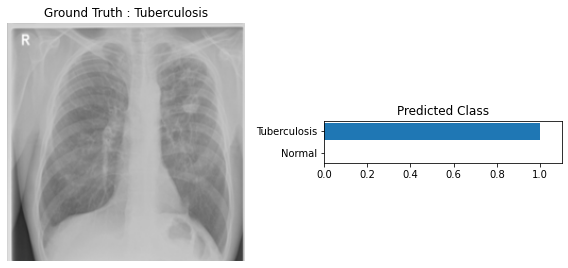

In [ ]:
import torch.nn.functional as F

image,label = testset[712] #30

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

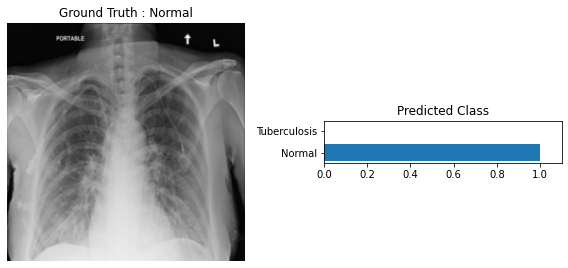

In [ ]:
import torch.nn.functional as F

image,label = testset[45] #30

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

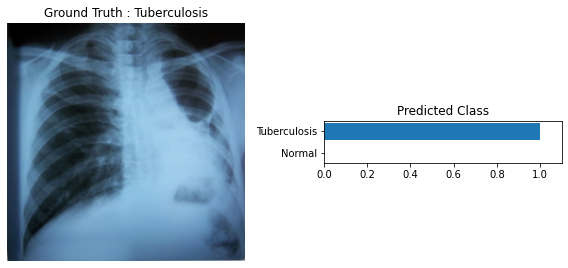

In [ ]:
import torch.nn.functional as F

image,label = testset[822]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

## **Conclusion**

The EfficientNet model was used to classify Tuberculosis and Normal images from chest x-rays. In order to handle class imbalance different augmentations were applied on Tuberculosis training set of images. It made mostly accurate and a few false predictions. The confusion matrices above show that model achieved good accuracy. 